In [1]:
# Build a natural language processing (NLP) model to perform sentiment analysis on social media posts or product reviews
# This File is built and run on Kaggle Notebook

In [2]:
import os
import pandas as pd
import numpy as np
import bz2
import re
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

2024-07-31 09:20:03.360600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 09:20:03.360754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 09:20:03.490858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# File paths for the dataset
train_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
test_path = '/kaggle/input/amazonreviews/test.ft.txt.bz2'

In [4]:
def assign_labels_and_comments(file, max_lines=None):
    """
    Assign labels and comments from the dataset file.

    Parameters:
    file (str): Path to the file.
    max_lines (int): Maximum number of lines to read from the file.

    Returns:
    tuple: Numpy array of labels and list of comments.
    """
    labels = []
    comments = []
    for i, line in enumerate(bz2.BZ2File(file)):
        if max_lines and i >= max_lines:
            break
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)  # Label is the 10th character, converting '2' to 1 and '1' to 0
        comments.append(x[10:].strip())  # Comment starts from the 11th character
    return np.array(labels), comments

In [5]:
# Load and preprocess the dataset
train_labels, train_comments = assign_labels_and_comments(train_path, max_lines=500000)
test_labels, test_comments = assign_labels_and_comments(test_path)

In [6]:
def processed_comments(texts):
    """
    Process comments by converting to lowercase, removing punctuation, and non-ASCII characters.

    Parameters:
    texts (list): List of text comments.

    Returns:
    list: List of processed comments.
    """
    not_alphanumeric = re.compile(r'[\W]')
    not_ascii = re.compile(r'[^a-z0-9\s]')
    processed_comments = []
    for text in texts:
        lower = text.lower()
        no_punctuation = not_alphanumeric.sub(r' ', lower)
        no_non_ascii = not_ascii.sub(r'', no_punctuation)
        processed_comments.append(no_non_ascii)
    return processed_comments

In [7]:
train_comments = processed_comments(train_comments)
test_comments = processed_comments(test_comments)

In [8]:
# Split the training data into training and validation sets
train_comments, val_comments, train_labels, val_labels = train_test_split(train_comments, train_labels, random_state=42, test_size=0.2)

In [9]:
# Tokenization and padding
max_words = 20000  # Maximum number of words to keep, based on word frequency
max_sequence_length = 300  # Maximum length of the sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_comments)

In [10]:
X_train = tokenizer.texts_to_sequences(train_comments)
X_val = tokenizer.texts_to_sequences(val_comments)
X_test = tokenizer.texts_to_sequences(test_comments)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_val = pad_sequences(X_val, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [11]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [12]:
def create_model(optimizer, activation_function, lstm_layers):
    """
    Create and compile a LSTM model.

    Parameters:
    optimizer (tf.keras.optimizers): Optimizer for the model.
    activation_function (str): Activation function for the output layer.
    lstm_layers (int): Number of LSTM layers.

    Returns:
    tf.keras.Model: Compiled LSTM model.
    """
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    for _ in range(lstm_layers):
        model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True))) 
        model.add(layers.Dropout(0.3))  
    model.add(layers.LSTM(128, return_sequences=False))
    model.add(layers.Dense(1, activation=activation_function))  
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model

# Configurations for the model training
configurations = [
    {"optimizer": optimizers.Adam(learning_rate=0.001), "activation_function": 'sigmoid', "lstm_layers": 2},
    {"optimizer": optimizers.Adam(learning_rate=0.001), "activation_function": 'relu', "lstm_layers": 3},
]

results = []
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [13]:
# Train and evaluate the models based on different configurations
for config in configurations:
    print(f"Training from Config: {config}")
    model = create_model(config["optimizer"], config["activation_function"], config["lstm_layers"])
    history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}, Accuracy: {accuracy}")
    
    results.append({"config": config, "loss": loss, "accuracy": accuracy})

Training from Config: {'optimizer': <keras.src.optimizers.adam.Adam object at 0x7cfba680f010>, 'activation_function': 'sigmoid', 'lstm_layers': 2}
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 383s 240ms/step - accuracy: 0.8547 - loss: 0.3253 - val_accuracy: 0.9302 - val_loss: 0.1810
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 380s 243ms/step - accuracy: 0.9430 - loss: 0.1550 - val_accuracy: 0.9371 - val_loss: 0.1711
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 380s 243ms/step - accuracy: 0.9562 - loss: 0.1234 - val_accuracy: 0.9360 - val_loss: 0.1888
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 380s 243ms/step - accuracy: 0.9661 - loss: 0.1002 - val_accuracy: 0.9349 - val_loss: 0.2007
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 380s 243ms/step - accuracy: 0.9744 - loss: 0.0786 - val_accuracy: 0.9307 - val_loss: 0.2015
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 279s 22ms/step - accuracy: 0.9348 - loss: 0.1767
Loss: 0.17465738952159882, Accuracy: 0.9353125095367432
Training from Config: {'optimizer': <keras.src.opt

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 380s 30ms/step


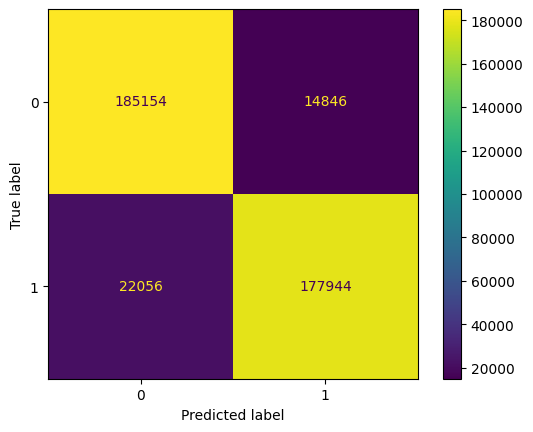

In [14]:
# Predictions and evaluation
predictions = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

In [15]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91    200000
           1       0.92      0.89      0.91    200000

    accuracy                           0.91    400000
   macro avg       0.91      0.91      0.91    400000
weighted avg       0.91      0.91      0.91    400000



In [16]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

rounded_accuracy = round(accuracy, 2)
rounded_precision = round(precision, 2)
rounded_recall = round(recall, 2)
rounded_f1 = round(f1, 2)

print(f"Accuracy: {rounded_accuracy}")
print(f"Precision: {rounded_precision}")
print(f"Recall: {rounded_recall}")
print(f"F1 Score: {rounded_f1}")

Accuracy: 0.91
Precision: 0.92
Recall: 0.89
F1 Score: 0.91
